In [28]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Load the data
def loadData():
    with np.load("notMNIST.npz") as data:
        Data, Target = data["images"], data["labels"]
        np.random.seed(521)
        randIndx = np.arange(len(Data))
        np.random.shuffle(randIndx)
        Data = Data[randIndx] / 255.0
        Target = Target[randIndx]
        trainData, trainTarget = Data[:10000], Target[:10000]
        validData, validTarget = Data[10000:16000], Target[10000:16000]
        testData, testTarget = Data[16000:], Target[16000:]
    return trainData, validData, testData, trainTarget, validTarget, testTarget

# Implementation of a neural network using only Numpy - trained using gradient descent with momentum
def convertOneHot(trainTarget, validTarget, testTarget):
    newtrain = np.zeros((trainTarget.shape[0], 10))
    newvalid = np.zeros((validTarget.shape[0], 10))
    newtest = np.zeros((testTarget.shape[0], 10))

    for item in range(0, trainTarget.shape[0]):
        newtrain[item][trainTarget[item]] = 1
    for item in range(0, validTarget.shape[0]):
        newvalid[item][validTarget[item]] = 1
    for item in range(0, testTarget.shape[0]):
        newtest[item][testTarget[item]] = 1
    return newtrain, newvalid, newtest


def shuffle(trainData, trainTarget):
    np.random.seed(421)
    randIndx = np.arange(len(trainData))
    target = trainTarget
    np.random.shuffle(randIndx)
    data, target = trainData[randIndx], target[randIndx]
    return data, target


def relu(x):
    return np.maximum(x, 0)

def softmax(x):
    x = x - np.max(x,axis=1).reshape(x.shape[0],1)
    x_sum = np.sum(np.exp(x),axis=1).reshape(x.shape[0],1)
    return np.divide(np.exp(x),x_sum)


def computeLayer(X, W, b):
    return np.add(np.matmul(X,W), b)

def CE(target, prediction):
    return (-1) * np.sum(np.multiply(target,np.log(prediction))) / target.shape[0]

def gradCE(target, prediction):
    return prediction - target

def train(trainData, trainTarget, validData, testData, num_epochs=200, input_size=28*28, num_units=1000, alpha = 1e-4, gamma = 0.99, class_num = 10):
    weight_hidden = np.random.normal(loc=0,scale=np.sqrt(2/(input_size+num_units)),size=(input_size,num_units))
    weight_output = np.random.normal(loc=0,scale=np.sqrt(2/(num_units+class_num)),size=(num_units,class_num))
    bias_hidden = np.random.normal(loc=0,scale=np.sqrt(2/(input_size+num_units)),size=(1,num_units))
    bias_output = np.random.normal(loc=0,scale=np.sqrt(2/(num_units+class_num)),size=(1,class_num))
    nu_old_hidden = np.full(shape=(input_size,num_units),fill_value=1e-5)
    nu_old_output = np.full(shape=(num_units,class_num),fill_value=1e-5)
    nu_new_hidden = np.zeros(shape=(input_size,num_units))
    nu_new_output = np.zeros(shape=(num_units,class_num))

    train_record = []
    valid_record = []
    test_record = []

    for iii in range(num_epochs):
        print(iii, end = ' ')

        output_hidden1 = relu(computeLayer(validData, weight_hidden, bias_hidden))
        prediction1 = softmax(computeLayer(output_hidden1, weight_output, bias_output))
        valid_record.append(prediction1)

        output_hidden2 = relu(computeLayer(testData, weight_hidden, bias_hidden))
        prediction2 = softmax(computeLayer(output_hidden2, weight_output, bias_output))
        test_record.append(prediction2)

        output_hidden = relu(computeLayer(trainData, weight_hidden, bias_hidden))
        prediction = softmax(computeLayer(output_hidden, weight_output, bias_output))
        train_record.append(prediction)


        gradient_o = gradCE(np.array(trainTarget), prediction)
        w_o = np.matmul(output_hidden.T, gradient_o) / prediction.shape[0]
        b_o = np.average(gradient_o,axis=0)
        nu_new_output = gamma * nu_old_output + alpha * w_o
        nu_old_output = nu_new_output
        weight_output = weight_output - nu_new_output
        bias_output = bias_output - alpha * b_o

        gradient_h = np.matmul(gradient_o, weight_output.T)
        w_h = np.matmul(np.array(trainData).T, np.where(output_hidden < 0, 0, gradient_h)) / prediction.shape[0]
        b_h = np.average(np.where(output_hidden < 0, 0, gradient_h),axis=0)
        nu_new_hidden = gamma * nu_old_hidden + alpha * w_h
        nu_old_hidden = nu_new_hidden
        weight_hidden = weight_hidden - nu_new_hidden
        bias_hidden = bias_hidden - alpha * b_h

    print('')

    return train_record, valid_record, test_record

def train_tensorflow(trainData, trainTarget, num_epochs=50):
    data = tf.placeholder(tf.float32, shape = [32,28,28,1])
    target = tf.placeholder(tf.float32, shape = [32,10])
    prediction = cnn(data)
    loss = tf.losses.softmax_cross_entropy(target,prediction)
    actual_label = tf.math.argmax(target, axis=1)
    predict_label = tf.math.argmax(prediction, axis=1)
    accuracy = tf.count_nonzero(tf.math.equal(actual_label, predict_label)) / 32
    optimizer = tf.train.AdamOptimizer(1e-4)
    optimizer = optimizer.minimize(loss)

    init = tf.global_variables_initializer()
    session = tf.InteractiveSession()
    session.run(init)

    accuracy_record = []
    loss_record = []

    iteration = trainData.shape[0] / 32
    for iii in range(num_epochs):
        print(iii)
        for i in range(iteration):
            batchData = trainData[i*32:(i+1)*32]
            batchTarget = trainTarget[i*32:(i+1)*32]
            op = session.run([optimizer], feed_dict={data:batchData, target:batchTarget})
        accuracy, loss = session.run([accuracy, loss], feed_dict={data:batchData, target:batchTarget})
        accuracy_record.append(accuracy)
        loss_record.append(loss)

    return loss_record, accuracy_record


def cnn(x):
    filter_1 = tf.get_variable("filter_1", shape=[3, 3, 1, 32], initializer=tf.contrib.layers.xavier_initializer())
    bc1 = tf.get_variable("bc1", shape=[32], initializer=tf.contrib.layers.xavier_initializer())
    wf1 = tf.get_variable("wf1", shape=[14*14*32, 28*28], initializer=tf.contrib.layers.xavier_initializer())
    bf1 = tf.get_variable("bf1", shape=[28*28], initializer=tf.contrib.layers.xavier_initializer())
    wf2 = tf.get_variable("wf2", shape=[28*28, 10], initializer=tf.contrib.layers.xavier_initializer())
    bf2 = tf.get_variable("bf2", shape=[10], initializer=tf.contrib.layers.xavier_initializer())

    conv1 = conv2d(x, filter_1, bc1)
    conv1 = batchNormalization(conv1)
    conv1 = maxpool2d(conv1)
    conv1 = tf.reshape(conv1, [-1])
    fc1 = tf.nn.relu(tf.add(tf.linalg.matmul(conv1, wf1), bf1))
    fc2 = tf.nn.softmax(tf.add(tf.linalg.matmul(fc1, wf2), bf2))
    return fc2

def conv2d(x, filt, b, strides=1):
    # Conv2D wrapper, with bias and relu activation
    x = tf.nn.conv2d(x, filt, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

def batchNormalization(x):
    mean,variance = tf.nn.moments(x,axes=[0])
    return tf.nn.batch_normalization(x,mean=mean,variance=variance,offset=0,scale=1,variance_epsilon=1e-5)

def maxpool2d(x, k=2):
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1],padding='SAME')

def accuracy_calculation(target, record):
    acc = []
    for i in record:
        pred = np.argmax(i, axis=1)
        comparison = pred - target
        comparison = np.where(comparison != 0, 0, 1)
        percentage = np.sum(comparison) / target.shape[0]
        acc.append(percentage)

    i = 0
    flag = False

    while True:

        for p in range(1,11):
            if acc[i+p] > acc[i]:
                i = i+p
                break
            if i+p == len(acc) - 1 or p == 10:
                flag = True
                break

        if i == len(acc) - 1:
            flag = True

        if flag == True:
            return acc, i


def loss_calculation(target, record):
    loss_record = []

    for i in range(len(record)):
            loss = CE(target, record[i])
            loss_record.append(loss)

    return loss_record
#🐫总好牛啊


In [30]:
import matplotlib.pyplot as plt
import numpy as np

def part1():

    trainData, validData, testData, trainTarget, validTarget, testTarget = loadData()
    trainData = np.array([x.flatten() for x in trainData])
    validData = np.array([x.flatten() for x in validData])
    testData = np.array([x.flatten() for x in testData])


    newtrain, newvalid, newtest = convertOneHot(trainTarget, validTarget, testTarget)

    #1.3

    train_record, valid_record, test_record = train(trainData, newtrain, validData, testData)

    loss_train = loss_calculation(newtrain, train_record)
    loss_valid = loss_calculation(newvalid, valid_record)
    loss_test = loss_calculation(newtest, test_record)

    accuracy_train, _ = accuracy_calculation(trainTarget, train_record)
    accuracy_valid, early_stop = accuracy_calculation(validTarget, valid_record)
    accuracy_test, _ = accuracy_calculation(testTarget, test_record)

    plt.figure()
    plt.suptitle('Cross Entropy loss curves')
    plt.plot(loss_train,'',loss_valid,'',loss_test,'')
    plt.xlabel('epochs')
    plt.ylabel('losses')
    plt.grid()
    plt.legend(['Training Data Loss', 'Validation Data Loss', 'Test Data Loss'])
    plt.savefig('Cross_Entropy_loss.png')


    plt.figure()
    plt.suptitle('Cross Entropy accuracy curves')
    plt.plot(accuracy_train,'',accuracy_valid,'',accuracy_test,'')
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.grid()
    plt.legend(['Training Accuracy', 'Validation Accuracy', 'Test Accuracy'])
    plt.savefig('Cross_Entropy_accuracy.png')


    #1.4.2
    print("Early Stopping at epoch: {}".format(early_stop))
    print("Training early stop accuracy: {}".format(accuracy_train[early_stop]))
    print("Validation early stop accuracy: {}".format(accuracy_valid[early_stop]))
    print("Testing early stop accuracy: {}".format(accuracy_test[early_stop]))

    plt.figure()
    plt.suptitle('Early Stopping accuracy curves')
    plt.plot(accuracy_train,'',accuracy_valid,'',accuracy_test,'')
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.axvline(x=early_stop, ls='--')
    plt.grid()
    plt.legend(['Training Accuracy', 'Validation Accuracy', 'Test Accuracy'])
    plt.savefig('Early_Stopping_accuracy.png')


0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 
Early Stopping at epoch: 198
Training early stop accuracy: 0.8287
Validation early stop accuracy: 0.8248333333333333
Testing early stop accuracy: 0.8362701908957415


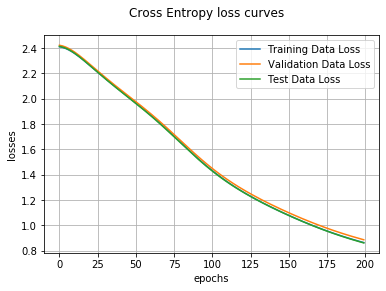

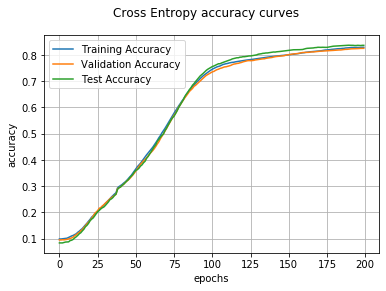

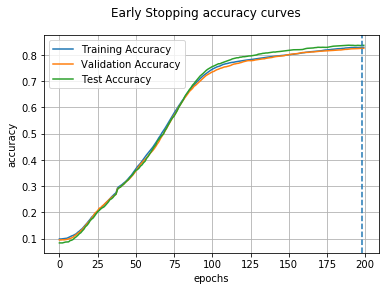

In [31]:
part1()